In [1]:
# --- NOTEBOOK 01: DATA ARCHAEOLOGY & HYGIENE ---

import numpy as np
import pandas as pd
import gc
import logging
import warnings

# 1. SETUP LOGGING (The Black Box Recorder)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)
warnings.filterwarnings('ignore')

# 2. CONFIGURATION (Built from your findings)
class Config:
    """
    Central Control Room.
    Parameters derived from Notebook 00 Analysis.
    """
    # Infrastructure
    TRAIN_PATH = 'data/application_train.csv'
    
    # Anomaly Thresholds (Found in Notebook 00)
    INCOME_CAP = 100_000_000     # You found max was 117M
    PENSIONER_CODE = 365243      # You found this Magic Number
    GENDER_EXCLUDE = 'XNA'       # You found 4 rows of this
    
    # Analysis Scope
    target_col = 'TARGET'

logger.info("Configuration Loaded. Ready to initiate pipeline.")

2026-01-16 14:01:14,941 - INFO - Configuration Loaded. Ready to initiate pipeline.


In [2]:
class MemoryReducer:
    """
    Optimizes memory usage by downcasting data types.
    Strictly avoids float16 to maintain model stability.
    """
    @staticmethod
    def reduce(df: pd.DataFrame) -> pd.DataFrame:
        start_mem = df.memory_usage().sum() / 1024**2
        logger.info(f"Initial Memory Usage: {start_mem:.2f} MB")
        
        for col in df.columns:
            col_type = df[col].dtype
            
            if col_type != object:
                c_min, c_max = df[col].min(), df[col].max()
                
                # Integer Optimization
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                
                # Float Optimization
                else:
                    # We stick to float32. float16 is too unstable for some sklearn algos.
                    if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                        
        end_mem = df.memory_usage().sum() / 1024**2
        logger.info(f"Final Memory Usage: {end_mem:.2f} MB (Reduced by {100 * (start_mem - end_mem) / start_mem:.1f}%)")
        return df

In [3]:
class DataCleaner:
    """
    Implements the cleaning logic defined in the Analysis Phase.
    """
    @staticmethod
    def clean_application_train(df: pd.DataFrame) -> pd.DataFrame:
        logger.info(f"Raw Shape: {df.shape}")
        
        # 1. Income Outlier (The 117M Guy)
        # We drop because it distorts Mean/Std for everyone else
        df = df[df['AMT_INCOME_TOTAL'] < Config.INCOME_CAP]
        
        # 2. Pensioner Magic Number (365243)
        # We flag it (Information) then nullify it (Math)
        df['DAYS_EMPLOYED_ANOM'] = (df['DAYS_EMPLOYED'] == Config.PENSIONER_CODE).astype('int8')
        df['DAYS_EMPLOYED'].replace(Config.PENSIONER_CODE, np.nan, inplace=True)
        
        # 3. Gender Noise
        df = df[df['CODE_GENDER'] != Config.GENDER_EXCLUDE]
        
        logger.info(f"Cleaned Shape: {df.shape}")
        return df

In [4]:
class DataAuditor:
    """
    Performs the post-cleaning health check.
    """
    @staticmethod
    def audit(df: pd.DataFrame):
        logger.info("--- POST-CLEANING AUDIT ---")
        
        # 1. Nullity Check
        nulls = df.isnull().mean().sort_values(ascending=False).head(5)
        print("\nTop 5 Missing Columns (%):")
        print(nulls * 100)
        
        # 2. Correlation Check (The Signal)
        # Select only numeric for correlation
        num_df = df.select_dtypes(include=['number'])
        corrs = num_df.corrwith(df['TARGET']).sort_values()
        
        print("\nTop 3 Negative Correlations (Safety):")
        print(corrs.head(3))
        
        print("\nTop 3 Positive Correlations (Risk):")
        print(corrs.tail(4).iloc[:-1]) # Exclude Target itself
        
        # 3. Skewness Check (Distribution Health)
        # Only check the main financial columns
        check_cols = ['AMT_INCOME_TOTAL', 'AMT_CREDIT']
        print("\nSkewness of Financials:")
        print(df[check_cols].skew())

In [5]:
# --- PIPELINE EXECUTION ---
def run_pipeline():
    # 1. Load
    df = pd.read_csv(Config.TRAIN_PATH)
    
    # 2. Shrink
    df = MemoryReducer.reduce(df)
    
    # 3. Clean
    df = DataCleaner.clean_application_train(df)
    
    # 4. Verify
    DataAuditor.audit(df)
    
    return df

# Trigger the Action
df_clean = run_pipeline()

2026-01-16 14:02:03,027 - INFO - Initial Memory Usage: 286.23 MB
2026-01-16 14:02:03,210 - INFO - Final Memory Usage: 128.16 MB (Reduced by 55.2%)
2026-01-16 14:02:03,210 - INFO - Raw Shape: (307511, 122)
2026-01-16 14:02:03,643 - INFO - Cleaned Shape: (307506, 123)
2026-01-16 14:02:03,658 - INFO - --- POST-CLEANING AUDIT ---



Top 5 Missing Columns (%):
COMMONAREA_MEDI             69.872133
COMMONAREA_AVG              69.872133
COMMONAREA_MODE             69.872133
NONLIVINGAPARTMENTS_MEDI    69.433117
NONLIVINGAPARTMENTS_MODE    69.433117
dtype: float64

Top 3 Negative Correlations (Safety):
EXT_SOURCE_3   -0.178906
EXT_SOURCE_2   -0.160452
EXT_SOURCE_1   -0.155319
dtype: float64

Top 3 Positive Correlations (Risk):
REGION_RATING_CLIENT_W_CITY    0.060897
DAYS_EMPLOYED                  0.074950
DAYS_BIRTH                     0.078235
dtype: float64

Skewness of Financials:
AMT_INCOME_TOTAL    26.975857
AMT_CREDIT           1.234758
dtype: float32


--- NULLITY STRUCTURE ANALYSIS ---

Top 10 Missing Features (%):
COMMONAREA_MODE             69.872133
COMMONAREA_AVG              69.872133
COMMONAREA_MEDI             69.872133
NONLIVINGAPARTMENTS_MEDI    69.433117
NONLIVINGAPARTMENTS_MODE    69.433117
NONLIVINGAPARTMENTS_AVG     69.433117
FONDKAPREMONT_MODE          68.386308
LIVINGAPARTMENTS_MEDI       68.355089
LIVINGAPARTMENTS_AVG        68.355089
LIVINGAPARTMENTS_MODE       68.355089
dtype: float64

Plotting Nullity Correlation Matrix...


<Figure size 1000x600 with 0 Axes>

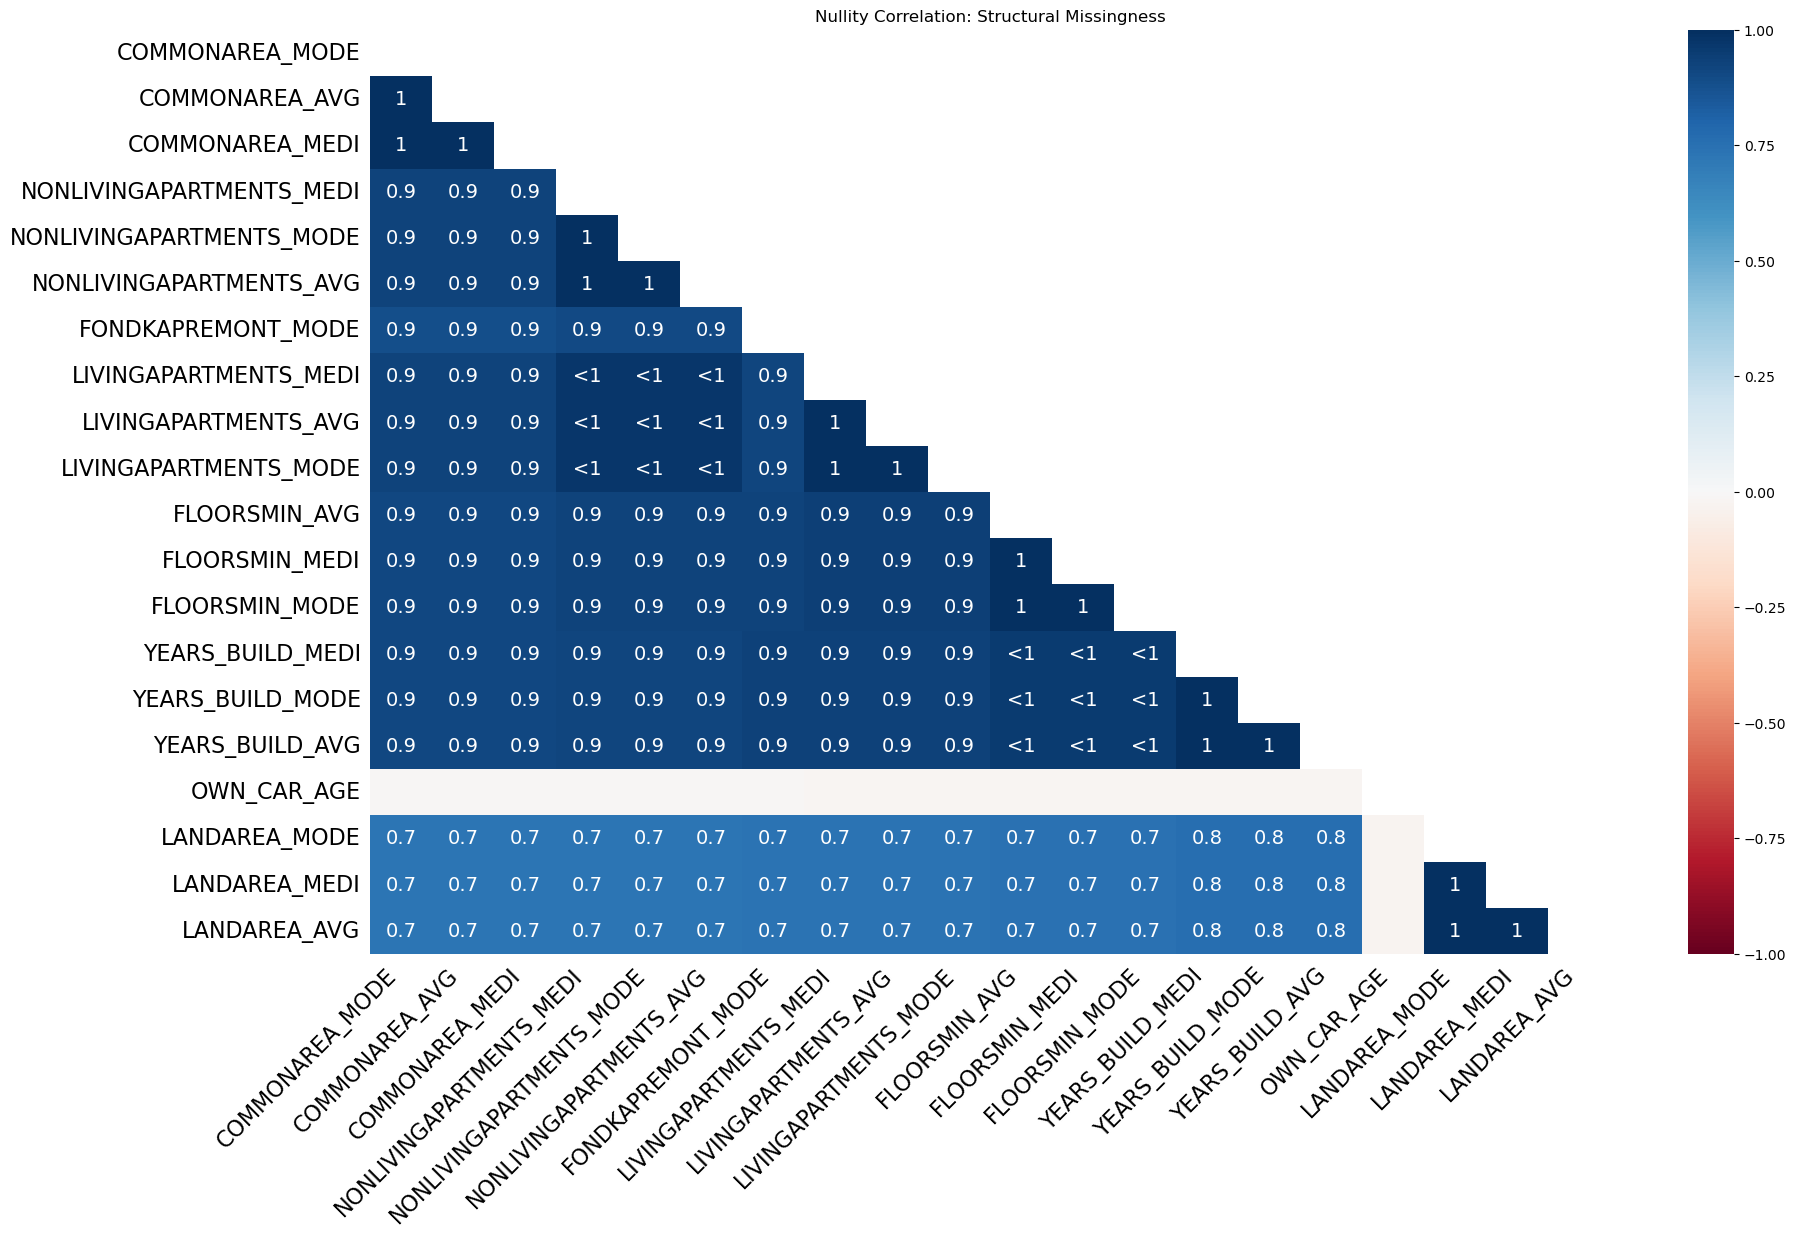

In [10]:
import missingno as msno  # You might need to pip install missingno
import matplotlib.pyplot as plt
import seaborn as sns

class NullityAuditor:
    """
    Analyzing the 'Physics of Nothing'.
    We check if missingness is random or structural.
    """
    @staticmethod
    def analyze_structure(df: pd.DataFrame):
        print("--- NULLITY STRUCTURE ANALYSIS ---")
        
        # 1. The "Swiss Cheese" Report (Percentage)
        null_counts = df.isnull().sum()
        null_pct = (null_counts / len(df)) * 100
        significant_nulls = null_pct[null_pct > 0].sort_values(ascending=False)
        
        print("\nTop 10 Missing Features (%):")
        print(significant_nulls.head(10))
        
        # 2. Structural Correlation (The Heatmap)
        # Do columns go missing together?
        # We sample 100k rows for speed
        print("\nPlotting Nullity Correlation Matrix...")
        
        # Select columns that actually have missing values
        cols_with_missing = significant_nulls.head(20).index.tolist() 
        
        if len(cols_with_missing) > 0:
            # msno heatmap shows correlation of missingness (1.0 = if A is missing, B is missing)
            plt.figure(figsize=(10, 6))
            msno.heatmap(df[cols_with_missing])
            plt.title("Nullity Correlation: Structural Missingness")
            plt.show()
        else:
            print("No missing values found to analyze.")

# EXECUTION (Add this to your pipeline)
NullityAuditor.analyze_structure(df_clean)

In [12]:
df_clean['AMT_INCOME_TOTAL'].sort_values().tail(5)

204564     4500000.0
131127     6750000.0
77768      9000000.0
246858    13500000.0
203693    18000090.0
Name: AMT_INCOME_TOTAL, dtype: float32

In [14]:
# --- END OF NOTEBOOK 01 ---

def save_checkpoint(df: pd.DataFrame, filename: str = 'clean_train.parquet'):
    """
    Saves the cleaned dataframe to Parquet format.
    Preserves dtypes (float32, int8) which CSV loses.
    """
    try:
        # Save to current directory
        df.to_parquet(filename, index=False)
        logger.info(f"Successfully saved {filename} with shape {df.shape}")
        
        # Verify file exists
        import os
        size = os.path.getsize(filename) / 1024**2
        logger.info(f"File Size: {size:.2f} MB")
        
    except Exception as e:
        logger.error(f"Failed to save parquet: {e}")

# Execute
save_checkpoint(df_clean)

2026-01-16 16:50:53,661 - INFO - Successfully saved clean_train.parquet with shape (307506, 123)
2026-01-16 16:50:53,662 - INFO - File Size: 20.39 MB
